# Example Codes

Dependencies

In [1]:
%pip install numpy scipy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 17.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 17.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 14.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 15.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 15.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import scipy.signal as sig
import scipy.fft as fft

a = np.array(range(10))
b = np.zeros(shape=(10))
b[0] = 1
b[1] = 1
print(a.shape)
print(b.shape)
# Convolution is commutative; order doesn't have any effect on output
c = sig.convolve(a, b)


(10,)
(10,)


[(5+0j), (1+0j), (2+0j), ] | F0 Result = (8+0j)
[(5+0j), (-0.4999999999999998-0.8660254037844387j), (-1.0000000000000009+1.7320508075688767j), ] | F1 Result = (3.499999999999999+0.866025403784438j)
[(5+0j), (-0.5000000000000004+0.8660254037844384j), (-0.9999999999999984-1.7320508075688783j), ] | F2 Result = (3.5000000000000018-0.8660254037844399j)
Even: [1]
Odd: [np.complex128(-1-1.2246467991473532e-16j)]
Even: [0.-1.2246468e-16j]
Odd: [np.complex128(-0.4999999999999998-0.8660254037844387j)]
SciPy FFT: [8. -0.j        3.5+0.8660254j 3.5-0.8660254j]
My FFT: [np.complex128(8+0j), np.complex128(3.499999999999999+0.866025403784438j), np.complex128(3.5000000000000018-0.8660254037844399j)]
My FFT_R2: [-0.5-0.8660254j]


/home/cag0050mobile/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/cag0050mobile/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


ValueError: x and y must have same first dimension, but have shapes (3,) and (1,)

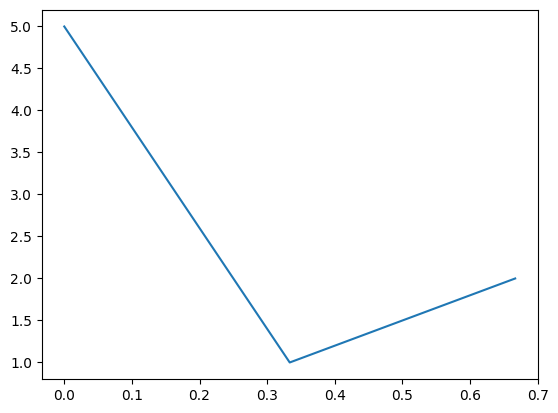

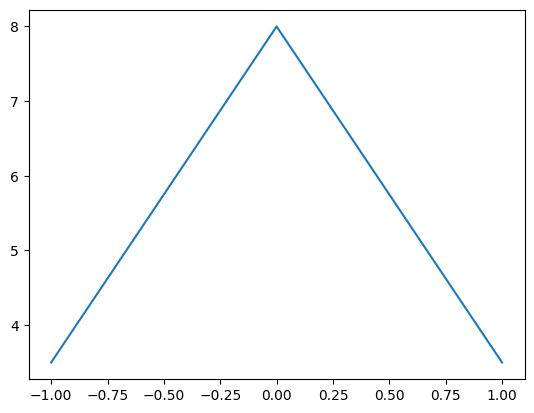

In [16]:
from matplotlib import pyplot as plt
import scipy.fft as scipyFFT


def myDFT(signal : list) -> list:
    fft = []
    N = len(signal)
    for idx, component in enumerate(signal):
        n = component
        fft.append(0)
        print("[", end="")
        for jdx, sample in enumerate(signal):
            exponential = np.exp(-(1j * 2 * np.pi * idx * jdx) / N)
            fft[idx] += signal[jdx] * exponential
            print(f"{signal[jdx] * exponential}", end=", ")
        print("]", end="")
        print(f" | F{idx} Result = {fft[idx]}")
    return fft

def myFFT_Radix2(signal):
    N = len(signal)
    if (N == 1):
        return [N]
    sigE = signal[0::2]
    sigO = signal[1::2]
    # print(f"E:{sigE}")
    # print(f"O:{sigO}")
    fftE = np.array(myFFT_Radix2(sigE))
    fftO = np.array(myFFT_Radix2(sigO))
    fftO = [np.exp(-(1j * 2 * np.pi) / N) * fftO[k] for k in range(N//2)]
    # k = range(0, int(N/2))
    # exponent = np.array(exponent)**k
    # fftO = np.multiply(fftO, exponent)
    print(f"Even: {fftE}")
    print(f"Odd: {fftO}")
    return fftE + fftO

samplingFreq = 3
duration = 1
N = int(samplingFreq * duration)

time = np.linspace(0, duration, N, endpoint=False)
#signal = np.sin(10.0 * 2.0*np.pi*time) + 0.5*np.sin(25.0 * 2.0*np.pi*time)
signal = [5, 1, 2]

signalFFT = scipyFFT.fft(signal)
mySignalFFT = myDFT(signal)
mySignalFFT_R2 = myFFT_Radix2(signal)
print(f"SciPy FFT: {signalFFT}")
print(f"My FFT: {mySignalFFT}")
print(f"My FFT_R2: {mySignalFFT_R2}")

fft_freq = scipyFFT.fftfreq(N, 1/samplingFreq)
fft_freq_shift = scipyFFT.fftshift(fft_freq)

signalFFT_shift = scipyFFT.fftshift(signalFFT)
mySignalFFT_shift = scipyFFT.fftshift(mySignalFFT)
mySignalFFT_R2_shift = scipyFFT.fftshift(mySignalFFT_R2)

plt.figure(1)
plt.plot(time, signal)
plt.figure(2)
plt.plot(fft_freq_shift, signalFFT_shift)
#plt.plot(fft_freq_shift, mySignalFFT_shift, "--o")
plt.plot(fft_freq_shift, mySignalFFT_R2_shift, "--o")
# Display only positive frequencies (MUST MULTIPLY MAGNITUDE BY 2)
# plt.xlim(0, samplingFreq/2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("SciPy FFT of Signal")

plt.figure(3)
plt.plot(time, scipyFFT.ifft(signalFFT))



ValueError: x and y must have same first dimension, but have shapes (10,) and (100,)

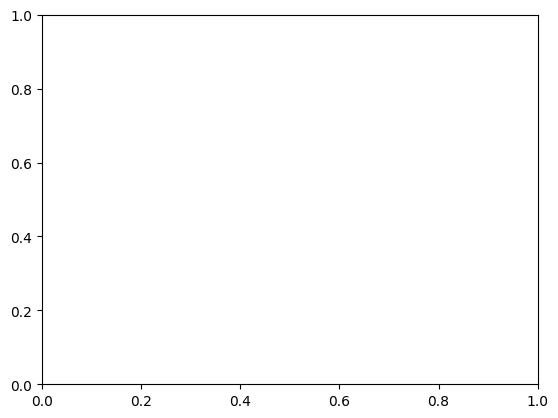

In [66]:
from matplotlib import pyplot as plt
x = range(10)

plt.plot(x, a, x, b, x, c[0:10])